# Connecticut Dickey-Fuller Tests & Modeling

We've focused on the top three zip codes for Connecticut based on the ROI from 1996 to 2018, meaning if you bought in 1996 and sold in 2018, how much value was added to your home.

For our purposes, we'll be looking at 06820 - Darien, 06068 - Salisbury, 06793 - Washington as our best zip codes to buy in.

Before we model, we first must satisfy the assumption of stationarity. Stationarity means that there is a constant mean and variance - or in other words, the mean and variance are not a function of time. We do so by running a Dickey-Fuller test where the null hypothesis is that there is no stationarity. In the case that there is in fact no stationarity, we will have to difference our data and rerun the Dickey-Fuller test. We repeat the process until the stationarity requirement is met.

Before we model, let's first import the necessary libraries.

In [307]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

import warnings
warnings.simplefilter('ignore') 

First, we need to read in the csv that we filtered for our top zip codes and melted our date data to be in long form.

In [308]:
topzip = pd.read_csv('topzip_timeseries.csv')
topzip

,time,RegionID,Zipcode,City,State,Metro,CountyName,SizeRank,AveragePrice,ROI,value
0,1996-04-01,60545,7030,Hoboken,NJ,New York,Hudson,58,9.577774e+05,5.148210,301600.0
1,1996-04-01,62022,11211,New York,NY,New York,Kings,118,5.951672e+05,11.189940,133200.0
2,1996-04-01,60639,7302,Jersey City,NJ,New York,Hudson,192,5.965913e+05,9.403061,137200.0
3,1996-04-01,62027,11216,New York,NY,New York,Kings,476,5.721717e+05,9.942505,146100.0
4,1996-04-01,62033,11222,New York,NY,New York,Kings,1156,6.400475e+05,10.535523,149200.0
...,...,...,...,...,...,...,...,...,...,...,...
2380,2018-04-01,62033,11222,New York,NY,New York,Kings,1156,6.400475e+05,10.535523,1721100.0
2381,2018-04-01,60461,6820,Darien,CT,Stamford,Fairfield,6037,1.128920e+06,1.514218,1388100.0
2382,2018-04-01,60796,7756,Neptune,NJ,New York,Monmouth,9759,3.456445e+05,4.418274,533700.0
2383,2018-04-01,60125,6068,Salisbury,CT,Torrington,Litchfield,13646,3.843411e+05,1.476514,474500.0


Now that we have our data, we want the time to be our index. Before we set the index, we also need to make sure it's in the 'datetime' format. This way we can slice the data later on.

In [309]:
topzip['time'] = pd.to_datetime(topzip['time'])
topzip.set_index('time', inplace=True)
topzip

,RegionID,Zipcode,City,State,Metro,CountyName,SizeRank,AveragePrice,ROI,value
time,,,,,,,,,,
1996-04-01,60545,7030,Hoboken,NJ,New York,Hudson,58,9.577774e+05,5.148210,301600.0
1996-04-01,62022,11211,New York,NY,New York,Kings,118,5.951672e+05,11.189940,133200.0
1996-04-01,60639,7302,Jersey City,NJ,New York,Hudson,192,5.965913e+05,9.403061,137200.0
1996-04-01,62027,11216,New York,NY,New York,Kings,476,5.721717e+05,9.942505,146100.0
1996-04-01,62033,11222,New York,NY,New York,Kings,1156,6.400475e+05,10.535523,149200.0
...,...,...,...,...,...,...,...,...,...,...
2018-04-01,62033,11222,New York,NY,New York,Kings,1156,6.400475e+05,10.535523,1721100.0
2018-04-01,60461,6820,Darien,CT,Stamford,Fairfield,6037,1.128920e+06,1.514218,1388100.0
2018-04-01,60796,7756,Neptune,NJ,New York,Monmouth,9759,3.456445e+05,4.418274,533700.0


Drop unnecessary columns before we start working to model for furture values.

In [310]:
topzip.drop(columns=['RegionID', 'City', 'State', 'Metro', 'CountyName', 'SizeRank', 'AveragePrice', 'ROI'], inplace=True)

In [311]:
topzip.head()

,Zipcode,value
time,,
1996-04-01,7030,301600.0
1996-04-01,11211,133200.0
1996-04-01,7302,137200.0
1996-04-01,11216,146100.0
1996-04-01,11222,149200.0


We want to only look at the zip codes in CT in this notebook. To do so, we filter for only the three zip codes in the state. Since we have two other states, we standardized the formulas to make it easier to copy over. the state_zips is the only variable we need to update for each state.

In [312]:
state_zips = [6820, 6068, 6793]

state = topzip[topzip['Zipcode'].isin(state_zips)]
state.head()

,Zipcode,value
time,,
1996-04-01,6820,552100.0
1996-04-01,6068,191600.0
1996-04-01,6793,280800.0
1996-05-01,6820,553400.0
1996-05-01,6068,191900.0


## Dickey-Fuller Testing

### First Zipcode: 06820 - Darien

We filter for the first zip code. We can do this by indexing the first item in the state_zips list.

In [169]:
first_zip = state[state['Zipcode'] == state_zips[0]]
first_zip.drop(columns=['Zipcode'], inplace=True)
first_zip.head()

,value
time,
1996-04-01,552100.0
1996-05-01,553400.0
1996-06-01,554800.0
1996-07-01,556000.0
1996-08-01,557000.0


We want to visualize the rolling mean and standard deviation. Stationarity calls for constant mean and variation. If stationarity exists, we should be able to see that in the rolling mean when we visualize it.

In [313]:
roll_mean = first_zip.rolling(window=12, center=False).mean()
roll_std = first_zip.rolling(window=12, center=False).std()

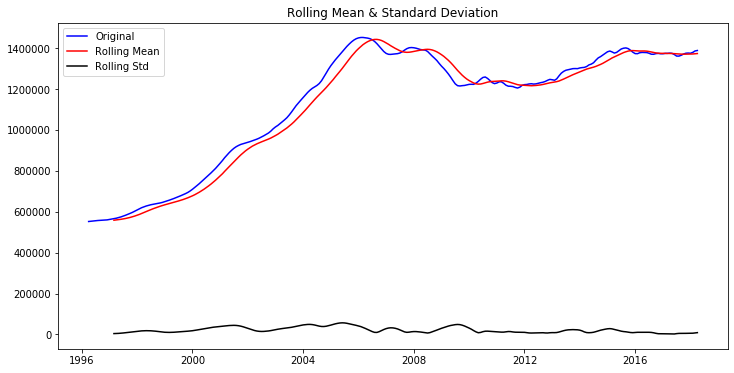

In [314]:
fig = plt.figure(figsize=(12,6))
plt.plot(first_zip.value, color='blue',label='Original')
plt.plot(roll_mean, color='red', label='Rolling Mean')
plt.plot(roll_std, color='black', label = 'Rolling Std')
plt.legend(loc='best')
plt.title('Rolling Mean & Standard Deviation')
plt.show()

From this graph, we can already tell there is no stationarity in our data -- yet. The varaince does appear relatively flat, but the mean is increasing up until ~2006 and then levels out. There's some trend present. Our Dickey-Fuller test will confirm.

In [315]:
from statsmodels.tsa.stattools import adfuller

dftest = adfuller(first_zip['value'])

dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value

print('p-value:',dfoutput[1])

if dfoutput[1] > .05:
        print('Fail to reject the null hypothesis. Data is not stationary.\n')
else:
        print('Reject the null hypothesis. Data is stationary.\n')

p-value: 0.21629346214937967
Fail to reject the null hypothesis. Data is not stationary.



In [316]:
print ('Results of Dickey-Fuller test: \n')

print(dfoutput)

Results of Dickey-Fuller test: 

Test Statistic                  -2.172724
p-value                          0.216293
#Lags Used                      16.000000
Number of Observations Used    248.000000
Critical Value (1%)             -3.456996
Critical Value (5%)             -2.873266
Critical Value (10%)            -2.573019
dtype: float64


Yep, we're unable to confirm stationarity. We'll need to difference our data. We difference our data and recheck for stationarity.

In [317]:
one_diff_first = first_zip['value'].diff().dropna()

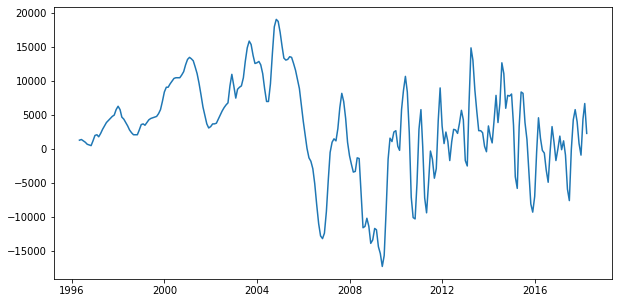

In [318]:
plt.figure(figsize=(10,5))
plt.plot(one_diff_first);

Our new data is starting to look more stationary. We then re-run the Dickey-Fuller test. If this test comes back and rejects the null, we can move on to the next zip code. If not, we difference a second time, or an order of 2.

In [319]:
dftest = adfuller(one_diff_first)

dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value

print('p-value:',dfoutput[1])

if dfoutput[1] > .05:
        print('Fail to reject the null hypothesis. Data is not stationary.\n')
else:
        print('Reject the null hypothesis. Data is stationary.\n')

p-value: 0.16860903977569947
Fail to reject the null hypothesis. Data is not stationary.



In [320]:
two_diff_first = one_diff_first.diff().dropna()

In [321]:
dftest = adfuller(two_diff_first)

dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value

print('p-value:',dfoutput[1])

if dfoutput[1] > .05:
        print('Fail to reject the null hypothesis. Data is not stationary.\n')
else:
        print('Reject the null hypothesis. Data is stationary.\n')

p-value: 6.683827826659577e-07
Reject the null hypothesis. Data is stationary.



In [322]:
print ('Results of Dickey-Fuller test: \n')

print(dfoutput)

Results of Dickey-Fuller test: 

Test Statistic                -5.728519e+00
p-value                        6.683828e-07
#Lags Used                     1.600000e+01
Number of Observations Used    2.460000e+02
Critical Value (1%)           -3.457215e+00
Critical Value (5%)           -2.873362e+00
Critical Value (10%)          -2.573070e+00
dtype: float64


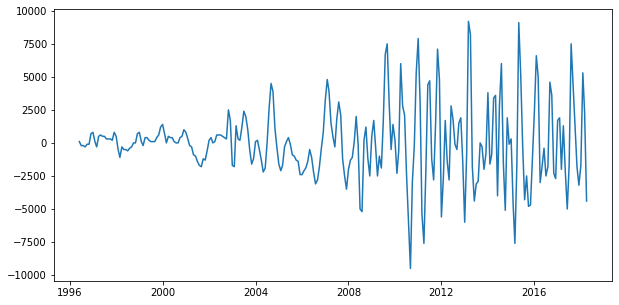

In [323]:
plt.figure(figsize=(10,5))
plt.plot(two_diff_first);

Our data is stationary! Our new distribution definitely looks much steadier and passes our Dickey-Fuller test. Below we've graphed the original distribution, rolling mean and rolling standard deviation and then the new values for those metrics after we differenced the data.

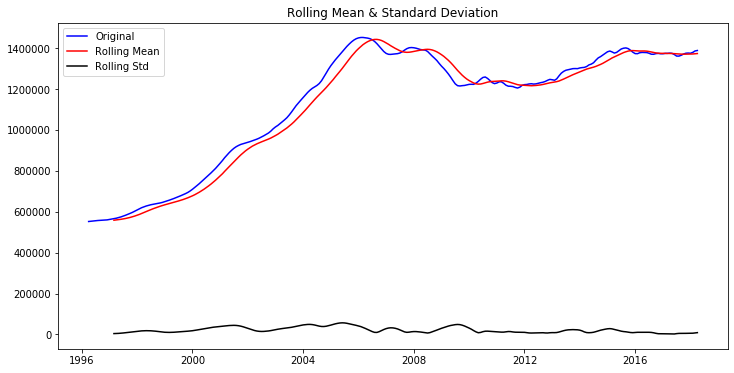

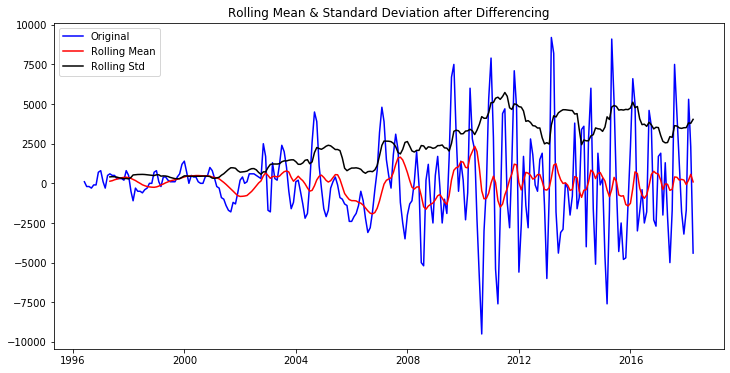

In [324]:
fig = plt.figure(figsize=(12,6))
plt.plot(first_zip.value, color='blue',label='Original')
plt.plot(roll_mean, color='red', label='Rolling Mean')
plt.plot(roll_std, color='black', label = 'Rolling Std')
plt.legend(loc='best')
plt.title('Rolling Mean & Standard Deviation')
plt.show()

diff_roll_mean = two_diff_first.rolling(window=12, center=False).mean()
diff_roll_std = two_diff_first.rolling(window=12, center=False).std()

fig = plt.figure(figsize=(12,6))
plt.plot(two_diff_first, color='blue',label='Original')
plt.plot(diff_roll_mean, color='red', label='Rolling Mean')
plt.plot(diff_roll_std, color='black', label = 'Rolling Std')
plt.legend(loc='best')
plt.title('Rolling Mean & Standard Deviation after Differencing')
plt.show()

Now that we have stationarity, we want to check the autocorrelation and partial autocorrelation charts. Based on our autocorrelation, it looks like the ideal value for p when we run our ARIMA model will be 3 and the ideal value for q is 2. We built our model to loop through multiple options for our order (p, d, and q values). We'll make sure to double check how 3 (our p value), 2 (the order of differencing it took to get stationarity) and 2 (our q value) performs.

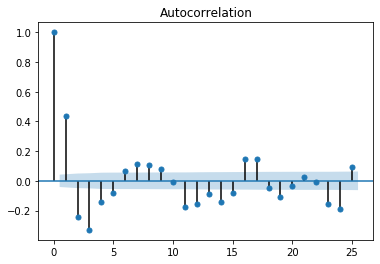

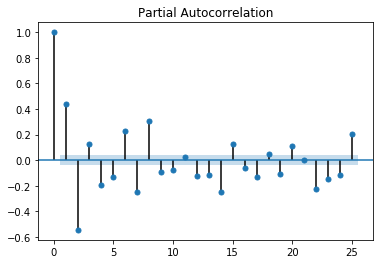

In [182]:
plot_acf(two_diff_first[:-1], alpha=0.5);
plot_pacf(two_diff_first[:-1], alpha=0.5);

### Second Zipcode: 06068 - Salisbury

For our second zip code, we'll repeat the same steps from the first zip code.

In [183]:
second_zip = state[state['Zipcode'] == state_zips[1]]
second_zip.drop(columns=['Zipcode'], inplace=True)
second_zip.head()

,value
time,
1996-04-01,191600.0
1996-05-01,191900.0
1996-06-01,192200.0
1996-07-01,192300.0
1996-08-01,192600.0


In [325]:
### calculate rolling mean & rolling std for the second zip

roll_mean = second_zip.rolling(window=12, center=False).mean()
roll_std = second_zip.rolling(window=12, center=False).std()

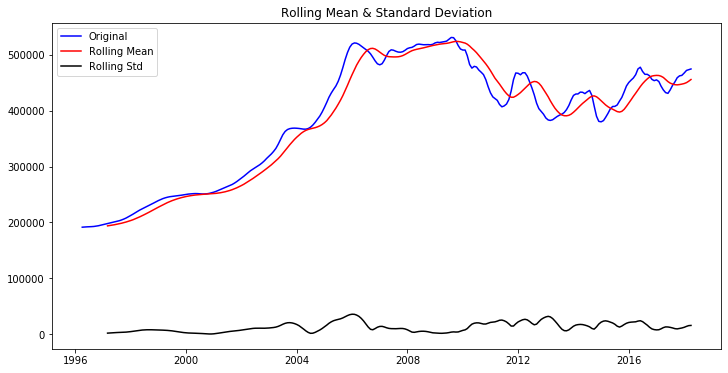

In [326]:
### plot our metrics

fig = plt.figure(figsize=(12,6))
plt.plot(second_zip.value, color='blue',label='Original')
plt.plot(roll_mean, color='red', label='Rolling Mean')
plt.plot(roll_std, color='black', label = 'Rolling Std')
plt.legend(loc='best')
plt.title('Rolling Mean & Standard Deviation')
plt.show()

In [327]:
from statsmodels.tsa.stattools import adfuller

dftest = adfuller(second_zip['value'])

dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value

print('p-value:',dfoutput[1])

if dfoutput[1] > .05:
        print('Fail to reject the null hypothesis. Data is not stationary.\n')
else:
        print('Reject the null hypothesis. Data is stationary.\n')

p-value: 0.3789496728748944
Fail to reject the null hypothesis. Data is not stationary.



In [328]:
print ('Results of Dickey-Fuller test: \n')

print(dfoutput)

Results of Dickey-Fuller test: 

Test Statistic                  -1.803048
p-value                          0.378950
#Lags Used                      16.000000
Number of Observations Used    248.000000
Critical Value (1%)             -3.456996
Critical Value (5%)             -2.873266
Critical Value (10%)            -2.573019
dtype: float64


In [329]:
one_diff_second = second_zip['value'].diff().dropna()

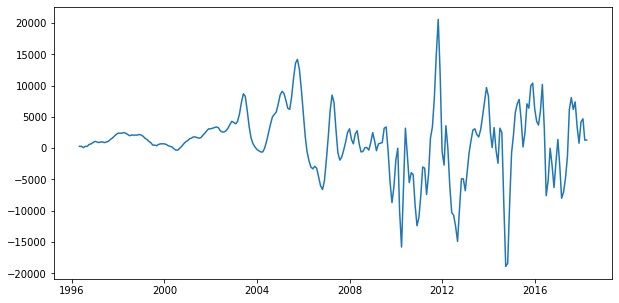

In [330]:
plt.figure(figsize=(10,5))
plt.plot(one_diff_second);

In [331]:
dftest = adfuller(one_diff_second)

dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value

print('p-value:',dfoutput[1])

if dfoutput[1] > .05:
        print('Fail to reject the null hypothesis. Data is not stationary.\n')
else:
        print('Reject the null hypothesis. Data is stationary.\n')

p-value: 0.002667352703430322
Reject the null hypothesis. Data is stationary.



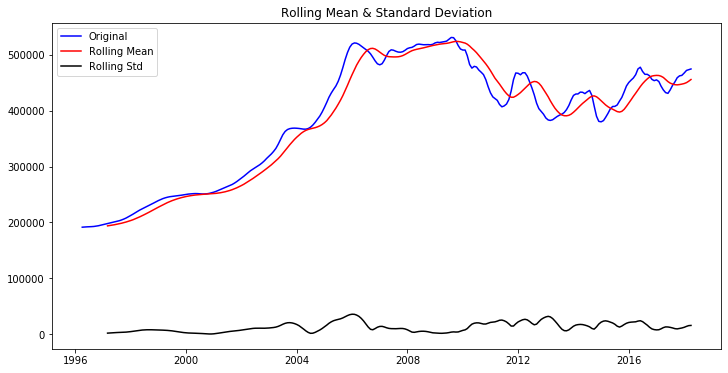

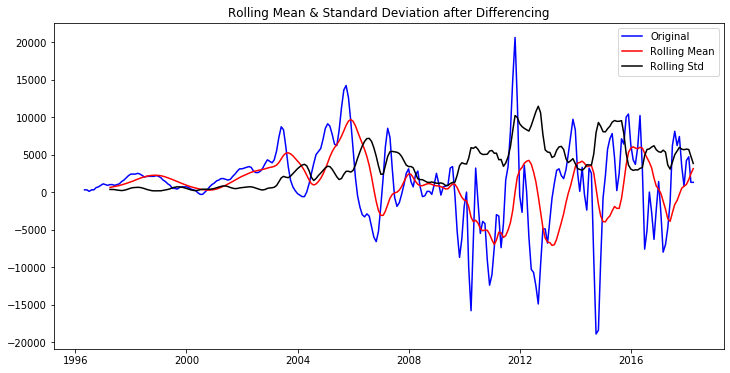

In [332]:
fig = plt.figure(figsize=(12,6))
plt.plot(second_zip.value, color='blue',label='Original')
plt.plot(roll_mean, color='red', label='Rolling Mean')
plt.plot(roll_std, color='black', label = 'Rolling Std')
plt.legend(loc='best')
plt.title('Rolling Mean & Standard Deviation')
plt.show()

diff_roll_mean = one_diff_second.rolling(window=12, center=False).mean()
diff_roll_std = one_diff_second.rolling(window=12, center=False).std()

fig = plt.figure(figsize=(12,6))
plt.plot(one_diff_second, color='blue',label='Original')
plt.plot(diff_roll_mean, color='red', label='Rolling Mean')
plt.plot(diff_roll_std, color='black', label = 'Rolling Std')
plt.legend(loc='best')
plt.title('Rolling Mean & Standard Deviation after Differencing')
plt.show()

In this instance, we only needed to difference once to acheive stationarity. We plotted our acf and pacf based on the once difference data. Looking at these graphs, it looks like p = 1 and q = 0 will provide the best metrics for our model.

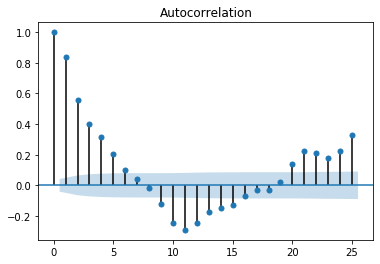

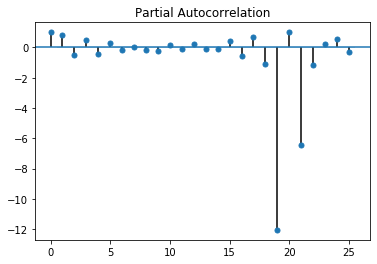

In [192]:
plot_acf(one_diff_second[:-1], alpha=0.5);
plot_pacf(one_diff_second[:-1], alpha=0.5);

### Third Zipcode: 06793 - Washington

And finally, for the third zip code, we need to repeat the steps. Check for stationarity using the Dickey-Fuller test, if stationarity is not present, difference the data and repeat until we acheive stationarity.

In [354]:
third_zip = state[state['Zipcode'] == state_zips[2]]
third_zip.drop(columns=['Zipcode'], inplace=True)
third_zip.head()

,value
time,
1996-04-01,280800.0
1996-05-01,282500.0
1996-06-01,284300.0
1996-07-01,286200.0
1996-08-01,288000.0


In [355]:
roll_mean = third_zip.rolling(window=12, center=False).mean()
roll_std = third_zip.rolling(window=12, center=False).std()

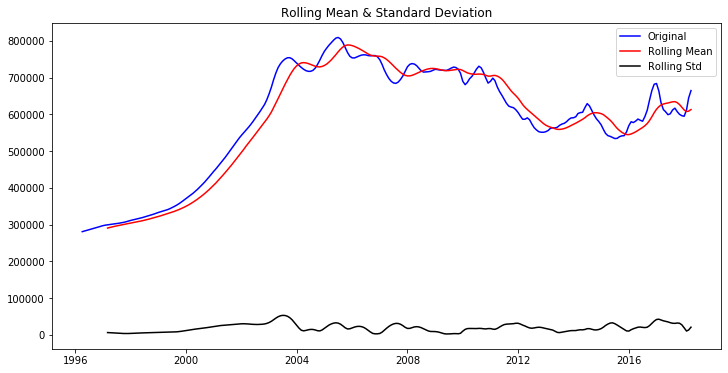

In [356]:
fig = plt.figure(figsize=(12,6))
plt.plot(third_zip.value, color='blue',label='Original')
plt.plot(roll_mean, color='red', label='Rolling Mean')
plt.plot(roll_std, color='black', label = 'Rolling Std')
plt.legend(loc='best')
plt.title('Rolling Mean & Standard Deviation')
plt.show()

In [357]:
from statsmodels.tsa.stattools import adfuller

dftest = adfuller(third_zip['value'])

dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value

print('p-value:',dfoutput[1])

if dfoutput[1] > .05:
        print('Fail to reject the null hypothesis. Data is not stationary.\n')
else:
        print('Reject the null hypothesis. Data is stationary.\n')

p-value: 0.21298196794972774
Fail to reject the null hypothesis. Data is not stationary.



In [358]:
print ('Results of Dickey-Fuller test: \n')

print(dfoutput)

Results of Dickey-Fuller test: 

Test Statistic                  -2.181625
p-value                          0.212982
#Lags Used                      16.000000
Number of Observations Used    248.000000
Critical Value (1%)             -3.456996
Critical Value (5%)             -2.873266
Critical Value (10%)            -2.573019
dtype: float64


In [359]:
one_diff_third = third_zip['value'].diff().dropna()

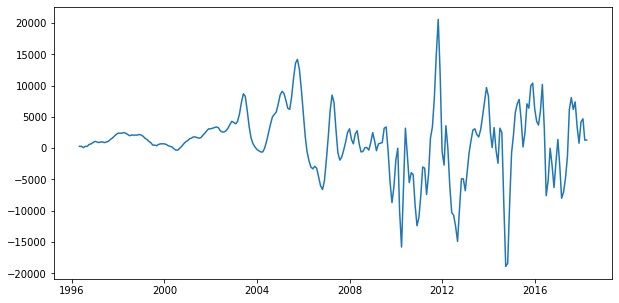

In [360]:
plt.figure(figsize=(10,5))
plt.plot(one_diff_second);

In [361]:
dftest = adfuller(one_diff_third)

dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value

print('p-value:',dfoutput[1])

if dfoutput[1] > .05:
        print('Fail to reject the null hypothesis. Data is not stationary.\n')
else:
        print('Reject the null hypothesis. Data is stationary.\n')

p-value: 0.05830079208558181
Fail to reject the null hypothesis. Data is not stationary.



In [362]:
two_diff_third = one_diff_third.diff().dropna()

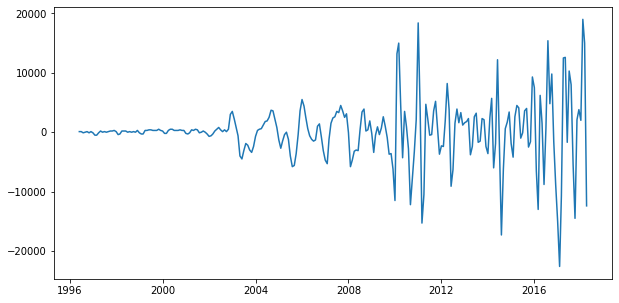

In [363]:
plt.figure(figsize=(10,5))
plt.plot(two_diff_third);

In [364]:
dftest = adfuller(two_diff_third)

dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value

print('p-value:',dfoutput[1])

if dfoutput[1] > .05:
        print('Fail to reject the null hypothesis. Data is not stationary.\n')
else:
        print('Reject the null hypothesis. Data is stationary.\n')

p-value: 8.576750370540442e-09
Reject the null hypothesis. Data is stationary.



In [365]:
print ('Results of Dickey-Fuller test: \n')

print(dfoutput)

Results of Dickey-Fuller test: 

Test Statistic                -6.556789e+00
p-value                        8.576750e-09
#Lags Used                     1.600000e+01
Number of Observations Used    2.460000e+02
Critical Value (1%)           -3.457215e+00
Critical Value (5%)           -2.873362e+00
Critical Value (10%)          -2.573070e+00
dtype: float64


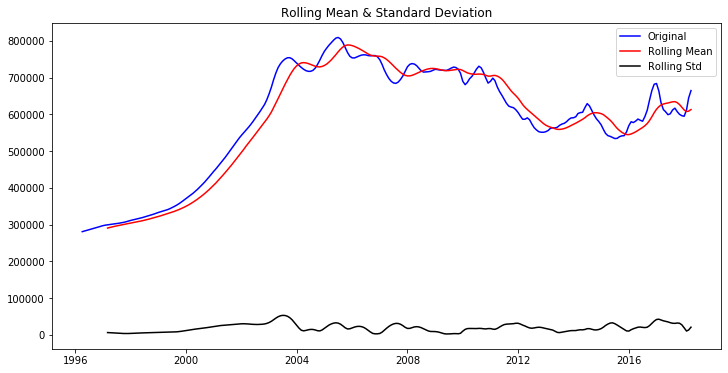

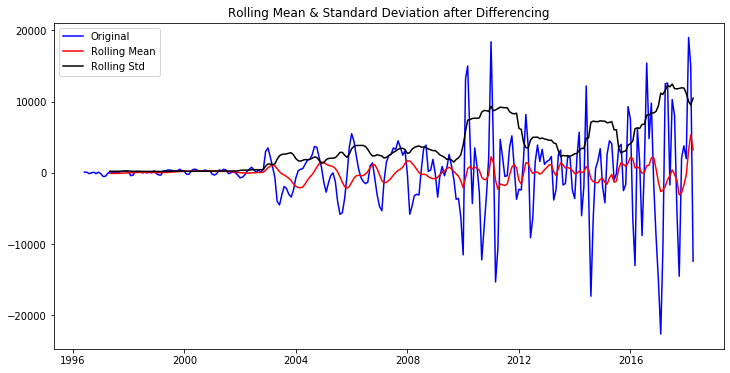

In [366]:
fig = plt.figure(figsize=(12,6))
plt.plot(third_zip.value, color='blue',label='Original')
plt.plot(roll_mean, color='red', label='Rolling Mean')
plt.plot(roll_std, color='black', label = 'Rolling Std')
plt.legend(loc='best')
plt.title('Rolling Mean & Standard Deviation')
plt.show()

diff_roll_mean = two_diff_third.rolling(window=12, center=False).mean()
diff_roll_std = two_diff_third.rolling(window=12, center=False).std()

fig = plt.figure(figsize=(12,6))
plt.plot(two_diff_third, color='blue',label='Original')
plt.plot(diff_roll_mean, color='red', label='Rolling Mean')
plt.plot(diff_roll_std, color='black', label = 'Rolling Std')
plt.legend(loc='best')
plt.title('Rolling Mean & Standard Deviation after Differencing')
plt.show()

After differencing the data twice, we can look at our new acf & pacf graphs. Based on these graphs, it looks like the ideal p is 1 and q should be 2. When we run our models, we'll look to see if our check ends up being the best parameters that give us the most accurate model.

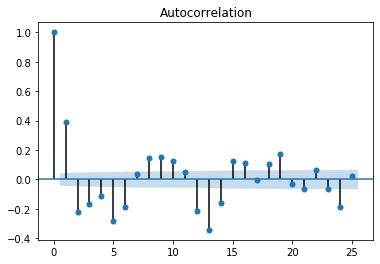

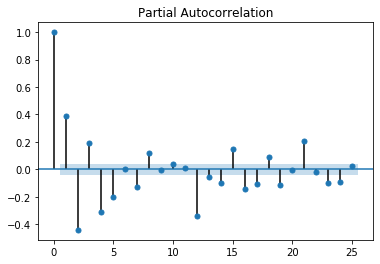

In [367]:
plot_acf(two_diff_third[:-1], alpha=0.5);
plot_pacf(two_diff_third[:-1], alpha=0.5);

## Modeling

Before we begin modeling, we first set a dataframe that we'll add to as we run through all the order parameters we've designated. The dataframe will provide us with our evaluation metrics. We're interested in balancing the AIC, BIC along with the MSE and RMSE for our test data.

In [370]:
global summary_df
summary_df = pd.DataFrame(columns = ['Zip', 'Order', 'AIC', 'BIC', 'test_mse', 'test_rmse'])
summary_df

,Zip,Order,AIC,BIC,test_mse,test_rmse


In [371]:
from numpy import linalg as LA
LinAlgError = np.linalg.LinAlgError

Now that we have the dataframe set up, we build functions to simplify the modeling process.

In [372]:
### first we created a list for different p, d, and q values we want to check to determine the best model.
### this list is manually entered.
orders = [(1, 0, 0), (1, 1, 0), (2, 1, 3), (3, 1, 1), (2, 2, 2), (4, 1, 1), (3, 2, 3), (3, 2, 1), (3, 2, 2), (1, 0, 1),
         (1, 1, 1), (2, 1, 1), (4, 2, 3), (4, 4, 4), (4, 3, 3), (1, 2, 2), (2, 2, 1), (0, 0, 0), (2, 1, 2), (2, 1, 0), 
         (3, 1, 0), (1, 2, 2), (0, 2, 1), (0, 2, 2)] 


def train_test(df):
    """
    We want to split our data. Because this is time series and not independent, we split our data where we're training
    the model on the older data and then testing the accuracy on the newer data.
    """
    train = df[:'2015-04']
    test = df['2015-05':]
    return train, test

def model_build(zipcode, df, orders):
    """
    This function will run through all of the different orders we've desinated above. We manually enter the zip code
    to later filter on, the dataframe we want to model as well as the list of orders. Should the ARIMA model return
    an error, we continue to the next order option.
    
    When the model successfully passes the order, it will add the evaluation metrics to the dataframe for us to review
    after all models are complete.
    """
    train, test = train_test(df)
    for i in orders:
#         print(i)
        try:
            zip_ = zipcode
            order = i
            model = ARIMA(train, order=i)
            fitted = model.fit(disp=-1)
            test_fc, se, conf = fitted.forecast(36, alpha=0.05)
            aic = round(fitted.aic, 2)
            bic = round(fitted.bic, 2)
            test_mse = round(mean_squared_error(test.values, test_fc), 2)
            test_rmse = round(np.sqrt(test_mse), 2)
            global summary_df
            summary_df = summary_df.append({'Zip': zip_, 'Order': str(order), 
                                                      'AIC': aic, 'BIC': bic,
                                                      'test_mse': test_mse, 
                                                      'test_rmse': test_rmse},
                                                     ignore_index=True)
        except (LinAlgError, ValueError):
            continue
        
    return summary_df

In [373]:
def best_model(df, order=(0,0,0)):
    """
    Once we evaluate all of the models we were able to run, this function will return the model summary to check for
    significance as well as a graph of our training data, actual values for the test data and the forecasted test data.
    """
    train, test = train_test(df)
#     print(test)
    no1_model = ARIMA(train, order=order)
    best_fit = no1_model.fit()
    test_fc, se, conf = best_fit.forecast(36, alpha=0.05)
    # Make as pandas series
    fc_series = pd.Series(test_fc, index=test.index)
#     print(fc_series)
    lower_series = pd.Series(conf[:, 0], index=test.index)
    upper_series = pd.Series(conf[:, 1], index=test.index)
    print(best_fit.summary())
    print('\n')
    print('\n')
    # Plot
    plt.figure(figsize=(12,5), dpi=100)
    plt.plot(train, label='training')
    plt.plot(test, label='actual')
    plt.plot(fc_series, label='forecast')
    plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.15)
    plt.title('Forecast vs Actuals')
    plt.legend(loc='upper left', fontsize=8)
    plt.show()

In [374]:
def future_predict(zipcode, df, order=(0,0,0)):
    """
    We want to be able to predict the future values for these zip codes. This function takes the best model parameters
    for each zip code and calculates the predicted values from 2018-2024 along with the ROI if one was to buy in 2018
    and sell in that year. It also plots these values so we can visually see the different values.
    """
    train, test = train_test(df)
    model = ARIMA(train, order=order)
    fit = model.fit()
    april_2018 = round(fit.forecast(36)[0][-1], 2)
    april_2019 = round(fit.forecast(48)[0][-1], 2)
    april_2020 = round(fit.forecast(60)[0][-1], 2)
    april_2021 = round(fit.forecast(72)[0][-1], 2)
    april_2022 = round(fit.forecast(84)[0][-1], 2)
    april_2023 = round(fit.forecast(96)[0][-1], 2)
    april_2024 = round(fit.forecast(108)[0][-1], 2)
    ROI_2019 = round(april_2019-april_2018, 2)
    ROI_2020 =round(april_2020-april_2018, 2)
    ROI_2021 =round(april_2021-april_2018, 2)
    ROI_2022 = round(april_2022-april_2018, 2)
    ROI_2023 = round(april_2023-april_2018, 2)
    ROI_2024 =  round(april_2024-april_2018, 2)
    dictionary1 = {'2019-04': ROI_2019, '2020-04': ROI_2020, '2021-04': ROI_2021,
                 '2022-04': ROI_2022, '2023-04':ROI_2023,'2024-04': ROI_2024} 
    dictionary = {'2018-04': april_2018, '2019-04': april_2019, '2020-04': april_2020, '2021-04': april_2021,
                 '2022-04': april_2022, '2023-04': april_2023, '2024-04': april_2024}
    dataframe = pd.DataFrame(dictionary.values(), index=dictionary.keys(), columns=['Predict_Value'])
#     print(dataframe)
    dataframe.plot(kind='bar', title="Future Home Values", figsize=(8, 4))
    dataframe1 = pd.DataFrame(dictionary1.values(), index=dictionary1.keys(), columns=['ROI'])
#     print(dataframe)
    dataframe1.plot(kind='bar', title="Retrun on Investment", figsize=(8, 4))
    print(zipcode)
    print("April 2018 actual value: ", df.value[-1])
    print("April 2018 forecasted value: ", april_2018)
    print("April 2019 forecasted value: ", april_2019, ", ROI: ", round(april_2019-april_2018, 2))
    print("April 2020 forecasted value: ", april_2020, ", ROI: ", round(april_2020-april_2018, 2))
    print("April 2021 forecasted value: ", april_2021, ", ROI: ", round(april_2021-april_2018, 2))
    print("April 2022 forecasted value: ", april_2022, ", ROI: ", round(april_2022-april_2018, 2))
    print("April 2023 forecasted value: ", april_2023, ", ROI: ", round(april_2023-april_2018, 2))
    print("April 2024 forecasted value: ", april_2024, ", ROI: ", round(april_2024-april_2018, 2))

In [375]:
### run the different models for each of the zip codes.

model_build('06820', first_zip, orders)
model_build('06068', second_zip, orders)
model_build('06798', third_zip, orders)

,Zip,Order,AIC,BIC,test_mse,test_rmse
0,06820,"(1, 0, 0)",4786.73,4797.03,9.642097e+07,9819.42
1,06820,"(1, 1, 0)",4228.82,4239.11,7.972804e+08,28236.15
2,06820,"(2, 1, 3)",4042.80,4066.80,2.205931e+09,46967.34
3,06820,"(3, 1, 1)",4095.42,4116.00,9.628159e+08,31029.27
4,06820,"(2, 2, 2)",4034.97,4055.52,3.734415e+09,61109.86
5,06820,"(4, 1, 1)",4096.07,4120.08,1.046961e+09,32356.78
6,06820,"(3, 2, 3)",4026.73,4054.13,9.180207e+07,9581.34
7,06820,"(3, 2, 1)",4083.87,4104.42,2.944291e+09,54261.32
8,06820,"(3, 2, 2)",4027.04,4051.01,9.361287e+08,30596.22
9,06820,"(2, 1, 1)",4111.28,4128.42,1.620560e+09,40256.18


In [376]:
first_zip_models = summary_df[summary_df['Zip'] == '06820']
second_zip_models = summary_df[summary_df['Zip'] == '06068'] 
third_zip_models = summary_df[summary_df['Zip'] == '06798'] 

## Evaluating Models

### First Zipcode: 06820 - Darien

Now that we have our models separated into their own dataframes, we can start to evaluate them. Starting with the first dataframe, we see that our first zip code ran through 18 models.

In [377]:
first_zip_models

,Zip,Order,AIC,BIC,test_mse,test_rmse
0,06820,"(1, 0, 0)",4786.73,4797.03,9.642097e+07,9819.42
1,06820,"(1, 1, 0)",4228.82,4239.11,7.972804e+08,28236.15
2,06820,"(2, 1, 3)",4042.80,4066.80,2.205931e+09,46967.34
3,06820,"(3, 1, 1)",4095.42,4116.00,9.628159e+08,31029.27
4,06820,"(2, 2, 2)",4034.97,4055.52,3.734415e+09,61109.86
5,06820,"(4, 1, 1)",4096.07,4120.08,1.046961e+09,32356.78
6,06820,"(3, 2, 3)",4026.73,4054.13,9.180207e+07,9581.34
7,06820,"(3, 2, 1)",4083.87,4104.42,2.944291e+09,54261.32
8,06820,"(3, 2, 2)",4027.04,4051.01,9.361287e+08,30596.22
9,06820,"(2, 1, 1)",4111.28,4128.42,1.620560e+09,40256.18


We want to see which of our models has the lowest AIC values. We also want to look the models with the lowest RMSE values to ultimately decide on the best parameters for our final model.

In [379]:
first_zip_models.sort_values('AIC', axis=0, ascending=True)[:3]

,Zip,Order,AIC,BIC,test_mse,test_rmse
6,06820,"(3, 2, 3)",4026.73,4054.13,9.180207e+07,9581.34
8,06820,"(3, 2, 2)",4027.04,4051.01,9.361287e+08,30596.22
15,06820,"(1, 2, 2)",4034.89,4052.01,1.639506e+09,40490.82


In [380]:
first_zip_models.sort_values('test_rmse', axis=0, ascending=True)[:3]

,Zip,Order,AIC,BIC,test_mse,test_rmse
6,06820,"(3, 2, 3)",4026.73,4054.13,9.180207e+07,9581.34
0,06820,"(1, 0, 0)",4786.73,4797.03,9.642097e+07,9819.42
1,06820,"(1, 1, 0)",4228.82,4239.11,7.972804e+08,28236.15


For our first zip code Darien, the best model uses the order (3, 2, 3). This model gives us not only the lowest AIC, but also the lowest test RMSE. We'll use this to in our best_model function to visualize our data and predictions.

                             ARIMA Model Results                              
Dep. Variable:               D2.value   No. Observations:                  227
Model:                 ARIMA(3, 2, 3)   Log Likelihood               -2005.365
Method:                       css-mle   S.D. of innovations           1637.959
Date:                Wed, 06 May 2020   AIC                           4026.730
Time:                        22:06:15   BIC                           4054.129
Sample:                    06-01-1996   HQIC                          4037.786
                         - 04-01-2015                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const             -6.3557    157.513     -0.040      0.968    -315.076     302.364
ar.L1.D2.value    -0.0879      0.237     -0.371      0.711      -0.553       0.377
ar.L2.D2.value     0.1215      0.170

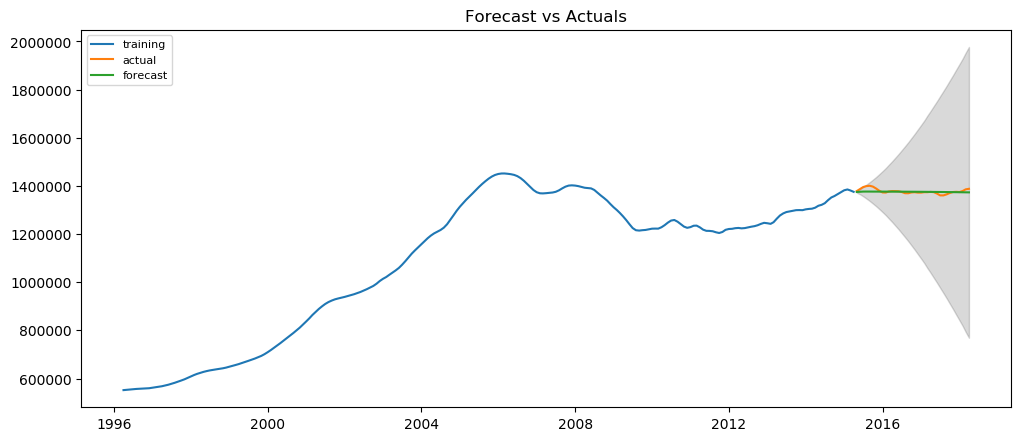

In [381]:
best_model(first_zip, order=(3, 2, 3))

Based on the summary, not all of our coefficients are significant, but unlike linear regression, the AR and MA values are not independent so we can't drop them to get rid of the noise. When we look at the graph, the green line of our predictions in really close to our actuals. It's also worth noting that prices in Darien, CT look to have plateaued in recent years. While this zip code has previously been a top performer in terms of return on investment, in the future, it might not be as good of a buy. Stay tuned!

### Second Zipcode: 06068 - Salisbury

In [384]:
### display total model recap
### the second zip code ran through 19 models.

second_zip_models

,Zip,Order,AIC,BIC,test_mse,test_rmse
18,06068,"(1, 0, 0)",4594.94,4605.24,3.261306e+09,57107.85
19,06068,"(1, 1, 0)",4265.89,4276.18,2.602870e+08,16133.41
20,06068,"(2, 1, 3)",4077.86,4101.87,9.531226e+08,30872.68
21,06068,"(3, 1, 1)",4102.33,4122.90,6.148321e+08,24795.81
22,06068,"(2, 2, 2)",4089.02,4109.57,3.582951e+09,59857.76
23,06068,"(4, 1, 1)",4090.18,4114.18,8.803116e+08,29670.04
24,06068,"(3, 2, 3)",4063.41,4090.81,4.515020e+09,67193.90
25,06068,"(3, 2, 1)",4096.65,4117.20,5.961869e+09,77213.14
26,06068,"(3, 2, 2)",4082.57,4106.54,4.160873e+09,64504.83
27,06068,"(2, 1, 1)",4121.96,4139.11,1.058174e+09,32529.59


In [385]:
second_zip_models.sort_values('AIC', axis=0, ascending=True)[:3]

,Zip,Order,AIC,BIC,test_mse,test_rmse
24,06068,"(3, 2, 3)",4063.41,4090.81,4.515020e+09,67193.90
28,06068,"(4, 2, 3)",4072.83,4103.66,4.621612e+09,67982.44
32,06068,"(2, 1, 2)",4077.70,4098.27,1.089112e+09,33001.70


In [386]:
second_zip_models.sort_values('test_rmse', axis=0, ascending=True)[:3]

,Zip,Order,AIC,BIC,test_mse,test_rmse
19,06068,"(1, 1, 0)",4265.89,4276.18,2.602870e+08,16133.41
34,06068,"(3, 1, 0)",4136.93,4154.08,4.638312e+08,21536.74
21,06068,"(3, 1, 1)",4102.33,4122.90,6.148321e+08,24795.81


What's interesting with our second zip is that the model with the lowest AIC is not in fact the lowest RMSE. This could indicate with this more complex model - the order is 3, 2, 3 - is overfitting to our training data. When we look at the lowest RMSE, 1, 1, 0 is the best model like we thought when we looked at the acf & pacf. We weighed the increase in AIC and decided to put more weight behind the test RMSE and choose 1, 1, 0 as our best model.

                             ARIMA Model Results                              
Dep. Variable:                D.value   No. Observations:                  228
Model:                 ARIMA(1, 1, 0)   Log Likelihood               -2129.946
Method:                       css-mle   S.D. of innovations           2752.021
Date:                Wed, 06 May 2020   AIC                           4265.893
Time:                        22:13:33   BIC                           4276.181
Sample:                    05-01-1996   HQIC                          4270.043
                         - 04-01-2015                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const          1038.5463   1203.263      0.863      0.388   -1319.807    3396.899
ar.L1.D.value     0.8521      0.034     24.930      0.000       0.785       0.919
                                    Root

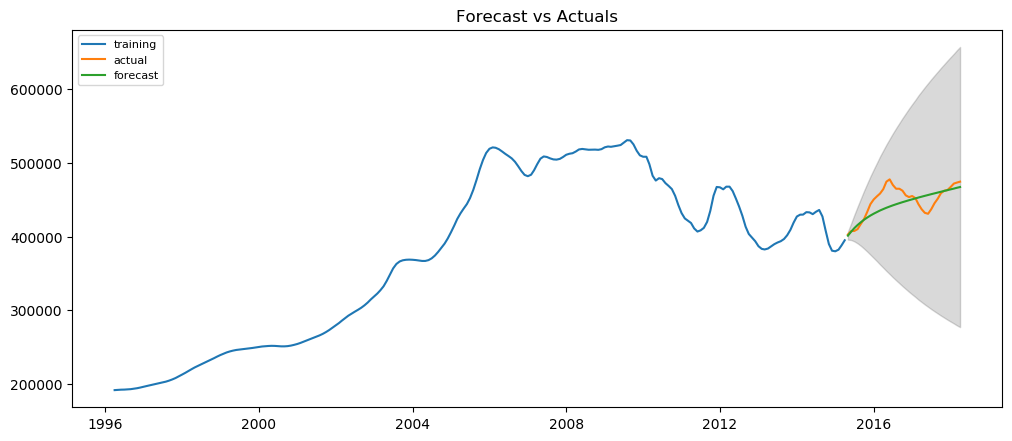

In [387]:
best_model(second_zip, order=(1, 1, 0))

There's definitely a lot more volatity with our Salisbury data. This model does an okay job trying to create a linear projection for the future.

### Third Zipcode: 06793 - Washington

In [389]:
### the third model ran through 18 models.

third_zip_models

,Zip,Order,AIC,BIC,test_mse,test_rmse
38,06798,"(1, 0, 0)",4736.14,4746.44,4.816285e+09,69399.46
39,06798,"(1, 1, 0)",4394.92,4405.21,6.789025e+09,82395.54
40,06798,"(2, 1, 3)",4250.93,4274.93,4.358458e+09,66018.62
41,06798,"(3, 1, 1)",4286.57,4307.15,5.485901e+09,74066.87
42,06798,"(2, 2, 2)",4274.20,4294.75,2.191647e+10,148042.11
43,06798,"(4, 1, 1)",4284.67,4308.67,4.058546e+09,63706.72
44,06798,"(3, 2, 1)",4285.13,4305.68,5.163488e+10,227233.10
45,06798,"(3, 2, 2)",4268.30,4292.28,2.509149e+10,158402.94
46,06798,"(1, 1, 1)",4297.39,4311.10,4.258092e+09,65254.06
47,06798,"(2, 1, 1)",4293.79,4310.93,3.350921e+09,57887.14


In [390]:
third_zip_models.sort_values('AIC', axis=0, ascending=True)[:3]

,Zip,Order,AIC,BIC,test_mse,test_rmse
40,06798,"(2, 1, 3)",4250.93,4274.93,4.358458e+09,66018.62
51,06798,"(2, 1, 2)",4253.31,4273.89,3.257920e+09,57078.19
45,06798,"(3, 2, 2)",4268.30,4292.28,2.509149e+10,158402.94


In [391]:
third_zip_models.sort_values('test_rmse', axis=0, ascending=True)[:3]

,Zip,Order,AIC,BIC,test_mse,test_rmse
50,06798,"(0, 0, 0)",6150.14,6157.01,2.012354e+09,44859.26
52,06798,"(2, 1, 0)",4338.74,4352.46,2.451758e+09,49515.23
51,06798,"(2, 1, 2)",4253.31,4273.89,3.257920e+09,57078.19


When looking at the acf & pacf graphs, it looked like 1, 2, 2 would be our best model, but in reality while it came back with a good AIC value, it wasn't accurate in predicting our test data. 1, 2, 2 looks to overfit to our training data. Instead, 0, 0, 0 actually has the lowest RMSE but that's just a white noise model and the AIC is crazy high. We've decided to go ahead and use 2, 1, 0 as our best model for predicting values.

                             ARIMA Model Results                              
Dep. Variable:                D.value   No. Observations:                  228
Model:                 ARIMA(2, 1, 0)   Log Likelihood               -2165.371
Method:                       css-mle   S.D. of innovations           3210.637
Date:                Wed, 06 May 2020   AIC                           4338.742
Time:                        22:21:08   BIC                           4352.459
Sample:                    05-01-1996   HQIC                          4344.276
                         - 04-01-2015                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const          1144.7368   1023.250      1.119      0.263    -860.796    3150.269
ar.L1.D.value     1.2692      0.058     21.881      0.000       1.156       1.383
ar.L2.D.value    -0.4757      0.058     

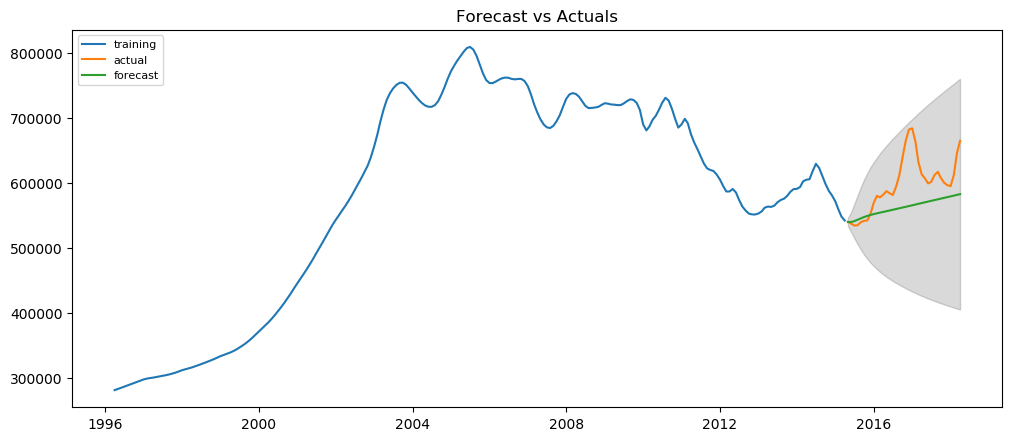

In [394]:
best_model(third_zip, order=(2, 1, 0))

For Washington, we again have some volatility in our data. This model is okay, but it looks like we're undervaluing the prices in this zip code. It would be worthwhile in future steps to see if there are other order values we're missing that could more accurately capture this trend. For now, this is our model with the smallest RMSE aside from 0, 0, 0 which just doesn't feel like a practical model for what we're doing.

## Predicting Future Home Values

Now that we have our best models, we want to predict values in the future. Thankfully, we have our future_predict function all set to predict the value each year from 2018-2024.

06820 - Darien
April 2018 actual value:  1388100.0
April 2018 forecasted value:  1373322.84
April 2019 forecasted value:  1370439.05 , ROI:  -2883.79
April 2020 forecasted value:  1366640.03 , ROI:  -6682.81
April 2021 forecasted value:  1361925.79 , ROI:  -11397.05
April 2022 forecasted value:  1356296.33 , ROI:  -17026.51
April 2023 forecasted value:  1349751.64 , ROI:  -23571.2
April 2024 forecasted value:  1342291.73 , ROI:  -31031.11


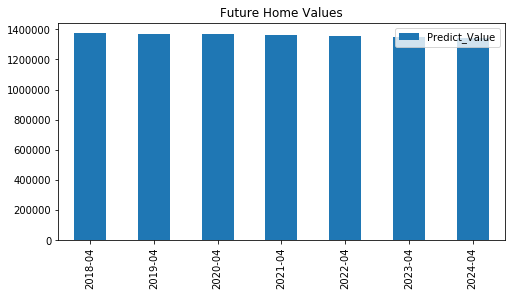

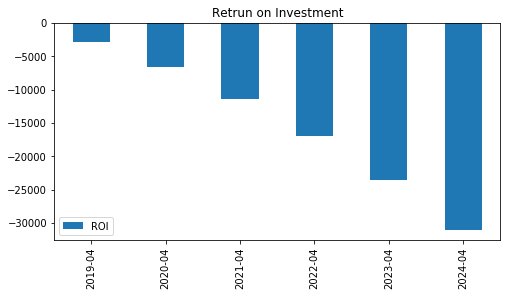

In [301]:
future_predict('06820 - Darien', first_zip, order=(3, 2, 3))

As we mentioned when looking at the training, actuals and prediction graph, Darien looks to have plateaued in terms of home values. As we get to 2024, the value really doesn't change much, but it does actually slightly decrease. As you see from the ROI graph, by 2024, if you bought in 2018, you stand to lose $30,000 dollars on your investment. Time to move!

06068 - Salisbury
April 2018 actual value:  474500.0
April 2018 forecasted value:  467210.35
April 2019 forecasted value:  479766.83 , ROI:  12556.48
April 2020 forecasted value:  492243.15 , ROI:  25032.8
April 2021 forecasted value:  504707.72 , ROI:  37497.37
April 2022 forecasted value:  517170.58 , ROI:  49960.23
April 2023 forecasted value:  529633.17 , ROI:  62422.82
April 2024 forecasted value:  542095.74 , ROI:  74885.39


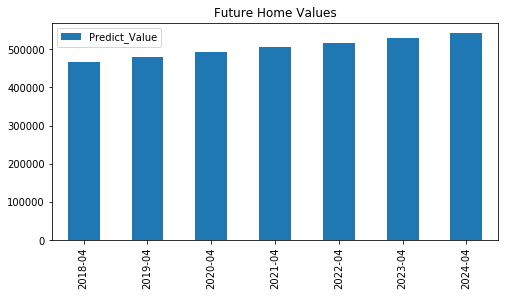

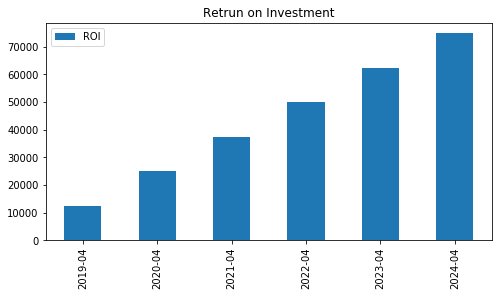

In [302]:
future_predict('06068 - Salisbury', second_zip, order=(1, 1, 0))

Salisbury is on a nice increase! Based on this graph, the average home price in 2024 is $\\$\$542k, up from 2018's actual April value of $475k. It's also nice to see that our predicted 2018 value is fairly close to the actual value. It's affordable and it's up & coming. Now someone tell me where Salisbury is...

06793 - Washington
April 2018 actual value:  664400.0
April 2018 forecasted value:  582376.28
April 2019 forecasted value:  596113.14 , ROI:  13736.86
April 2020 forecasted value:  609849.98 , ROI:  27473.7
April 2021 forecasted value:  623586.82 , ROI:  41210.54
April 2022 forecasted value:  637323.67 , ROI:  54947.39
April 2023 forecasted value:  651060.51 , ROI:  68684.23
April 2024 forecasted value:  664797.35 , ROI:  82421.07


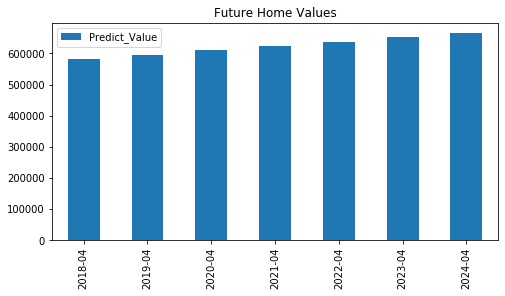

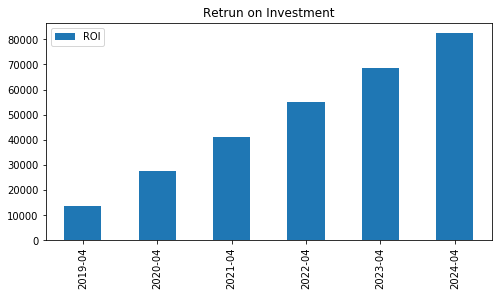

In [395]:
future_predict('06793 - Washington', third_zip, order=(2, 1, 0))

Definitely our most problematic model, Washinginton was a challenge to predict for. Based on our model, home values should be around $\\$\$665k by 2024, with a $82k ROI if you bought in 2018. We can see that our predicted value for 2018 is well below our actual. This would be a great future step to evaluate this model further and account of the uptick in later years better than our current model. Again, someone tell me where Washington, CT is. Might be time to buy a home.